# volVal trial structure generation, radd simulation, and experimental results

In [1]:
#write simulator for various trial structures
#function for trial structure, simulate results, then experimental 

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import random as rd
from matplotlib import animation, rc
from IPython.display import HTML 
import csv
import seaborn as sns
%matplotlib inline

In [3]:
def genChangePoint(constantChangePoint, lambdaV, nTrials):
#one problem -- gives one too many trials in the beginning. should not count first trial
#as changepoint
    #sample changePoint
    changePoint_vec = np.zeros((nTrials))
    changePoints = []

    if constantChangePoint == 0:
        i = 1
        while np.sum(changePoints) < nTrials-1:
            changePoints += list(np.random.poisson(lambdaV,i))   

        #if the sum(epochs) > nTrials, remove the last changePoint 
        #if we want to impose fewer constraints to prioritize integrity of 
        #random selection, we can relax the absolute # of trials 
        if np.sum(changePoints) >= nTrials:
            changePoints = changePoints[0:-1]       

        #convert to trial number indices 
        changeIdx = list(np.cumsum(changePoints))
        #mark change point 
        changePoint_vec[changeIdx] = 1 

    elif constantChangePoint == 1:
        changePoints = np.int(np.random.poisson(lambdaV,1))
        changePoint_vec[changePoints::changePoints] = 1 
        changeIdx = list(np.cumsum(np.repeat(changePoints, np.sum(changePoint_vec))))

    #     print(changeIdx)
    #     print(np.sum(changePoint_vec)*changePoints, changePoints)
    return changePoint_vec, changeIdx

In [4]:
def genStop(percStopTrials, lambdaStop, nTrials):

    #stop trials 
    nStopTrials = np.int(percStopTrials * nTrials)
    stopPoints = np.random.poisson(lambdaStop,nStopTrials) #length
    stopIdx = np.cumsum(stopPoints) #indices

    while stopIdx[-1] >= nTrials: 
        stopPoints = np.random.poisson(lambdaStop,nStopTrials)
        stopIdx = np.cumsum(stopPoints)

    #assign delays to the stop indices 
    nSamplesPerDelay = np.int(nStopTrials/len(ssd))
    ssd_vec = np.zeros((nTrials))
    ssd_vec[:] = np.nan

    np.random.shuffle(stopIdx)

    #need to reshape, otherwise broadcasting problems
    ssd_repeatedVal = np.reshape(np.repeat(ssd, nSamplesPerDelay),nStopTrials) 
    ssd_vec[stopIdx] = ssd_repeatedVal
    
    
    return ssd_vec

In [5]:
def genMuSigma(muMin, muMax, sigmaMin, changePoint_vec, changeIdx, nTrials):


    #means and sigma
    nEpochs = np.int(np.sum(changePoint_vec) + 2)
    mu_p = np.random.uniform(muMin, muMax, np.int(nEpochs/2))
    mu_n = -1*mu_p
    muRewardDelta = np.hstack((mu_p, mu_n))
    np.random.shuffle(muRewardDelta)

    #more control over separation between mean values of each epoch
    # muDiff = .05 #greater muDiff = less conflict BETWEEN epochs 
    # test=np.arange(muMin, muMax, muDiff)
    # muControl_shuffle = np.random.uniform(min(test), max(test), len(test))
    # print(test)

    sigmaMax = min(muMin,1-muMax) #needs to be chosen to ensure that r diff is !> 1 
    #choose smaller sigma (based on mu) to avoid violating boundary of 1 or 0 

    sigma = np.random.uniform(sigmaMin, sigmaMax, 1)
    sigma_vec = np.repeat(sigma, nTrials)

    # print(muRewardDelta_vec.size)


    #sample from a normal distribution to generate reward delta for each trial 
    rewardDelta = np.zeros((nTrials))

    #this adds 0 and the end idx to change idx
    chgidx = [0]+changeIdx+[nTrials-1]

    #constructs unique interval for each mu 
    intervals = [(chgidx[i],chgidx[i+1]) for i in range(len(chgidx)-1)]

    muRewardDelta_vec = np.zeros_like(rewardDelta)
    #each iterator is linked to respective range 
    #zip iterates over two lists simultaneously  
    for interval,mu in zip(intervals,muRewardDelta):
        nElements = interval[1]-interval[0]
        rewardDelta[interval[0]:interval[1]]= np.reshape(np.random.normal(mu,sigma,nElements), (nElements))
        muRewardDelta_vec[interval[0]:interval[1]]= np.reshape(np.repeat(mu,nElements), (nElements))

    #the last element needs to be assigned because of the interval const. above 
    #(range is not inclusive)
    rewardDelta[-1] = np.random.normal(muRewardDelta[-1], sigma, 1)
    muRewardDelta_vec[-1] = muRewardDelta[-1]

    return rewardDelta, muRewardDelta_vec, sigma_vec

In [6]:
def genBaseTargetReward(rewardDelta, nTrials):

    #reverse engineer the actual values for targets

    #assume baseline value of .5 for each
    rewardDelta_div = 0.5*rewardDelta 
    adjustedTargets = 0.5*np.ones((nTrials,2))

    #always add half and subtract half of target value
    adjustedTargets[:,0] +=  rewardDelta_div[:]
    adjustedTargets[:,1] -=  rewardDelta_div[:]

    t1_baseReward = adjustedTargets[:,0]
    t2_baseReward = adjustedTargets[:,1]


    # print(rewardDelta)
    return t1_baseReward, t2_baseReward

In [7]:
#function inputs for testing 
nTrials = 1000
lambdaV = 15
lambdaStop = 10  
ssd = np.array([200, 250, 300, 350, 450])

percStopTrials = .10
constantChangePoint = 0
muMin = .25
muMax = .8
sigmaMin = 0 

In [8]:
def generateTrialStructure(nTrials, lambdaV, lambdaStop, ssd, sigmaMin, percStopTrials, constantChangePoint):
    
    changePoint_vec, changeIdx = genChangePoint(constantChangePoint, lambdaV, nTrials)#refactoring 
    ssd_vec = genStop(percStopTrials, lambdaStop, nTrials)
    rewardDelta, muRewardDelta_vec, sigma_vec = genMuSigma(muMin, muMax, sigmaMin, 
                                 changePoint_vec, changeIdx, nTrials)
    t1_baseReward, t2_baseReward = genBaseTargetReward(rewardDelta, nTrials)
    
    return t1_baseReward, t2_baseReward, ssd_vec, changePoint_vec, rewardDelta, muRewardDelta_vec, sigma_vec

In [9]:
#test function call
(t1_baseReward, t2_baseReward, ssd_vec, changePoint_vec, 
 rewardDelta, muRewardDelta_vec, sigma_vec) = generateTrialStructure(nTrials, lambdaV, 
                                                            lambdaStop, ssd, sigmaMin, percStopTrials, constantChangePoint)

#small chance that reward diff. is > 1 or < 0. if so, re-sample. 
if np.any(t1_baseReward > 1) or np.any(t1_baseReward < 1) or np.any(t2_baseReward > 1) or np.any(t2_baseReward < 1): 
        (t1_baseReward, t2_baseReward, ssd_vec, changePoint_vec, 
     rewardDelta, muRewardDelta_vec, sigma_vec) = generateTrialStructure(nTrials, lambdaV, 
                                                                lambdaStop, ssd, sigmaMin,percStopTrials, constantChangePoint)
    

## print parameters to a csv file 

In [10]:
taskParameters = np.array((t1_baseReward, t2_baseReward, ssd_vec, changePoint_vec, rewardDelta, 
            muRewardDelta_vec, sigma_vec))
taskParameters = np.matrix.transpose(taskParameters)
header = ("t1_baseReward, t2_baseReward, ssd_vec, changePoint_vec, rewardDelta, muRewardDelta, sigma_vec")
#was sigmaDelta, but held constant for this exp.         
np.savetxt('VolVal_TrialStructure.csv',taskParameters, header = header, delimiter=',', comments = '', fmt='%f')

In [11]:
#call function 
#simulate 
#experimental data 


# static plots

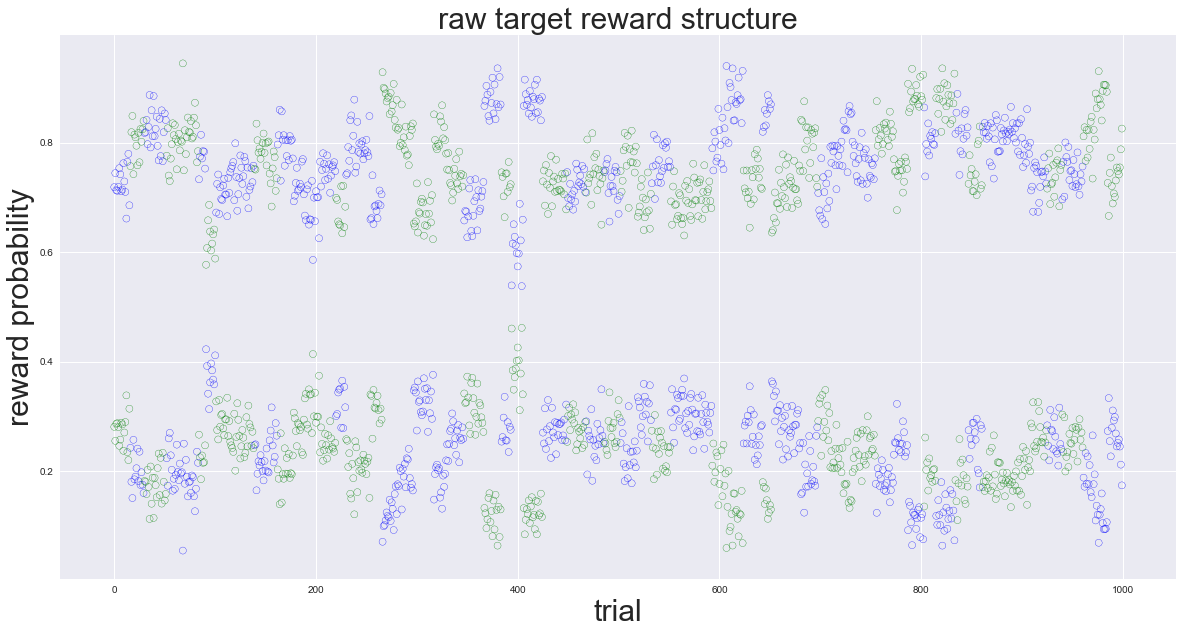

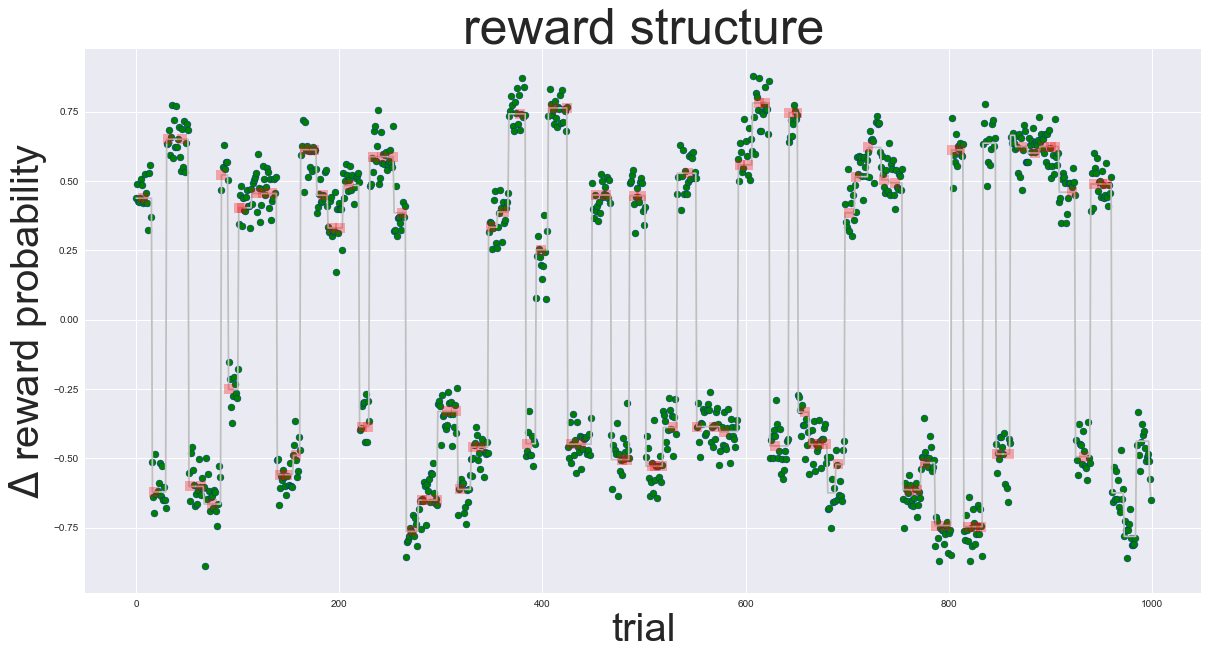

In [29]:
plt.figure(figsize=(20, 10))
x = np.arange(0,nTrials)


plt.title("raw target reward structure",fontsize = 30)
plt.xlabel("trial", fontsize = 30)
plt.ylabel("reward probability", fontsize = 30)
plt.legend(["t1", "t2"])
plt.scatter(x, t1_baseReward, facecolors='none',edgecolors='b')
plt.scatter(x, t2_baseReward, facecolors='none',edgecolors='g')
plt.savefig('test.pdf')

stop_idx = np.isfinite(ssd_vec)

plt.figure(figsize=(20, 10))
plt.title("reward structure", fontsize = 50)
plt.xlabel("trial", fontsize = 40)
plt.ylabel("$\Delta$ reward probability", fontsize = 40)
plt.scatter(x, rewardDelta, edgecolor='b', facecolor = 'g')
plt.plot(muRewardDelta_vec, '0.75')
plt.plot(x[stop_idx], muRewardDelta_vec[stop_idx], 'rs', markersize = 10, alpha = .3)
ax = plt.gca()
ax.grid(True)
plt.savefig('.pdf')
plt.show()


In [30]:
#lingering concerns 
#create as .py so this can be called as a function 
#animate 
#think a little more about the if statement above, make concise 

# animate trial structure

In [14]:
# # First set up the figure, the axis, and the plot element we want to animate
# fig, ax = plt.subplots()

# ax.set_xlim(( -2, 2))
# ax.set_ylim((-2, 2))

# sinegraph, = ax.plot([], [])
# dot, = ax.plot([], [],'o', color='red')

# x = np.linspace(0, 2, 1000)
# y = np.cos(x)

# # initialization function: plot the background of each frame
# def init():
#     dot.set_data([], [])
#     return (dot,)

# # animation function. This is called sequentially
# def animate(i): 
# #     y2 = np.ones(0, 2, 1000)
# #     jitter = np.random.normal(0, 1, (100,1))
# #     y=np.linspace(-1, 1, num=1000) * (x - 0.01 * i)
#     sinegraph.set_data(x[:i],y[:i])
#     dot.set_data(x[i],y[i])
#     return (dot,)

# # call the animator. blit=True means only re-draw the parts that have changed.
# anim = animation.FuncAnimation(fig, animate, init_func=init,
#                                frames=50, interval=10000, blit=True)
# HTML(anim.to_html5_video())